# Perceptron and back propagation

## Some stuffs to begin with


In [34]:
from functools import reduce

import matplotlib.pyplot as plt
import numpy as np

np.random.seed(0)

In [35]:
def glorot(size):
    limit = np.sqrt(6.0 / sum(size))
    return np.random.uniform(-limit, limit, size)


def prime(fn, x):
    return (fn(x + 1e-8) - fn(x - 1e-8)) / (2 * 1e-8)


def sel(y_hat, y):
    return 0.5 * (y - y_hat) ** 2


# def sel_prime(y_hat, y):
#     return -(y - y_hat)


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


# def sigmoid_prime(y):
#     return y * (1 - y)


def relu(x):
    return x * (x > 0)


# def relu_prime(y):
#     return 1 * (y > 0)


def tanh(x):
    return np.tanh(x)


# def tanh_prime(y):
#     return 1 - y**2


def dense(x, w, b):
    return x @ w + b


## Setup

let $lr$ a constant in [0, 1]

let $x$, $y$ 2 vectors, where:

- $x$ is the input of dimension $(k, n)$
- $y$ is the expected output of dimension $(k, m)$

let $w$, $b$ 2 matrices, where

- $w$ is the weights of the layer of dimension $(n, m)$
- $b$ the bias of the layer of dimension $(1, m)$


In [36]:
x = np.array(
    [
        [0, 0],
        [0, 1],
        [1, 0],
        [1, 1],
    ]
)
y_true = np.array(
    [
        [0],
        [1],
        [1],
        [0],
    ]
)

## Forward pass

We will compute the forward and backward pass of a one dense layer with $n$ inputs and $m$ outputs with an activation function of type $relu$.

**Compute the linear transformation of $x$**

```math
\hat{z} = \hat{x} w + b
```

Then give some non linearity by applying the activation function

```math
\hat{y} = relu(\hat{z}), relu: x \mapsto xH(x)
```

where H is the Heaviside step function

```math
H(x) = \begin{cases}
   1 &\text{if } x > 0 \\
   0 &\text{if } x <= 0
\end{cases}
```

**Compute the $loss$ between the output $\hat{y}$ and the expected output $y$**

```math
loss(\hat{y}, y) = \frac{1}{2}(y - \hat{y})^2 \\
```



In [37]:
def call(model, x):
    return reduce(lambda m, z: m + [z(m[-1])], model, [x])

## Backward pass

We want to know how much we need to adjust our weights and biases of the layer to minimize the loss function. Basically we need to substract the gradients of the loss along w and b. It is basically a Newton algorithm to find a minima of the forward function minimizing the loss.

**Compute the gradient of the $loss$ along $w$**

```math
\tag{a} \nabla{loss(\hat{y}, y)} \ldotp w = \frac{\partial{loss(\hat{y}, y)}}{\partial{w}}
```

Using the chain rules, we got

```math
\tag{b} \frac{\partial{loss(\hat{y}, y)}}{\partial{w}} = \frac{\partial{loss(\hat{y}, y)}}{\partial{\hat{y}}} \frac{\partial{\hat{y}}}{\partial{\hat{z}}} \frac{\partial{\hat{z}}}{\partial{w}}
```

where

```math
\tag{c}  \frac{\partial{loss(\hat{y}, y)}}{\partial{\hat{y}}} = -(y - \hat{y}) = \hat{y} - y
```

```math
\tag{d}  \frac{\partial{\hat{y}}}{\partial{\hat{z}}} = \frac{\partial{relu(\hat{z})}}{\partial{\hat{z}}} = \frac{\partial{(\hat{z}H(\hat{z}))}}{\partial{\hat{z}}} = 1 * \begin{cases}
   1 &\text{if } \hat{z} > 0 \\
   0 &\text{if } \hat{z} <= 0
\end{cases} = H(\hat{z})
```

```math
\tag{e}  \frac{\partial{(x w + b)}}{\partial{w}} = x^T
```

Combining all together:

```math
\boxed{\nabla{loss(\hat{y}, y)} \ldotp w =  x^T \otimes (\hat{y} - y) H(\hat{z})}
```

**Compute the gradient of the $loss$ along $b$**

```math
\tag{a} \nabla{loss(\hat{y}, y)} \ldotp b = \frac{\partial{loss(\hat{y}, y)}}{\partial{b}}
```

Using the chain rules, we got

```math
\tag{b} \frac{\partial{loss(\hat{y}, y)}}{\partial{b}} = \frac{\partial{loss(\hat{y}, y)}}{\partial{\hat{y}}} \frac{\partial{\hat{y}}}{\partial{\hat{z}}} \frac{\partial{\hat{z}}}{\partial{b}}
```

where

```math
\tag{c}  \frac{\partial{loss(\hat{y}, y)}}{\partial{\hat{y}}} = -(y - \hat{y}) = \hat{y} - y
```

```math
\tag{d}  \frac{\partial{\hat{y}}}{\partial{\hat{z}}} = \frac{\partial{relu(\hat{z})}}{\partial{\hat{z}}} = \frac{\partial{(\hat{z}H(\hat{z}))}}{\partial{\hat{z}}} = 1 * \begin{cases}
   1 &\text{if } \hat{z} > 0 \\
   0 &\text{if } \hat{z} <= 0
\end{cases} = H(\hat{z})
```

```math
\tag{e}  \frac{\partial{(x w + b)}}{\partial{b}} = 1
```

Combining all together:

```math
\boxed{\nabla{loss(\hat{y}, y)} \ldotp b = (\hat{y} - y) H(\hat{z})}
```

**Update the w and b matrices with the respective gradients of the loss.**

```math
\boxed{
   \begin{aligned}
   w = w - lr * \nabla{loss(\hat{y}, y)} \ldotp w \\
   b = b - lr * \nabla{loss(\hat{y}, y)} \ldotp b
   \end{aligned}
}
```

Now, we need to pass the gradient of the loss to the next layer of the neural network and then perform the same calculation as above.

**Compute the gradient of the $loss$ along $\hat{x}$**

```math
\tag{a} \nabla{loss(\hat{y}, y)} \ldotp \hat{x} = \frac{\partial{loss(\hat{y}, y)}}{\partial{\hat{x}}}
```

Using the chain rules, we got

```math
\tag{b} \frac{\partial{loss(\hat{y}, y)}}{\partial{\hat{x}}} = \frac{\partial{loss(\hat{y}, y)}}{\partial{\hat{y}}} \frac{\partial{\hat{y}}}{\partial{\hat{z}}} \frac{\partial{\hat{z}}}{\partial{\hat{x}}}
```

where

```math
\tag{c}  \frac{\partial{loss(\hat{y}, y)}}{\partial{\hat{y}}} = -(y - \hat{y}) = \hat{y} - y
```

```math
\tag{d}  \frac{\partial{\hat{y}}}{\partial{\hat{z}}} = \frac{\partial{relu(\hat{z})}}{\partial{\hat{z}}} = \frac{\partial{(\hat{z}H(\hat{z}))}}{\partial{\hat{z}}} = 1 * \begin{cases}
   1 &\text{if } \hat{z} >= 0 \\
   0 &\text{if } \hat{z} < 0
\end{cases} = H(\hat{z})
```

```math
\tag{e}  \frac{\partial{(x w + b)}}{\partial{x}} = w^T
```

Combining all together:

```math
\boxed{\nabla{loss(\hat{y}, y)} \ldotp \hat{x} = (\hat{y} - y) H(\hat{z}) \otimes w^T}
```

**Finally we can pass the gradient of the loss to the next layer (Hence gradient descent).**

In [48]:
def dense_grads(x, grad_loss):
    dw = x.T @ grad_loss
    db = np.sum(grad_loss, axis=0, keepdims=True)
    return dw, db


def update_weights(w, b, dw, db, lr):
    w -= lr * dw
    b -= lr * db

def fit(model, w, b, lr, loss_fn, z):
    # Compute loss gradient along y_pred
    grad_loss = prime(loss_fn, z[-1])
    
    for i in range(len(model) // 2):
        # Compute loss gradient along the activation function
        grad_loss = grad_loss * prime(model[-(i * 2 + 1)], z[-(i * 2 + 2)])

        # Compute the loss gradient along the dense layer
        grad_w, grad_b = dense_grads(z[-(i * 2 + 3)], grad_loss)
        grad_loss = grad_loss @ w[-(i + 1)].T

        update_weights(w[-(i + 1)], b[-(i + 1)], grad_w, grad_b, lr)

In [ ]:
w = [glorot((2, 4)), glorot((4, 1))]
b = [np.zeros((1, 4)), np.zeros((1, 1))]

model = [
    lambda x: dense(x, w[0], b[0]),
    tanh,
    lambda x: dense(x, w[1], b[1]),
    sigmoid,
]

lr = 0.001
loss_fn = lambda x: sel(x, y_true)
y_pred = np.zeros(y_true.shape)

for _ in range(100_000):
    # Forward
    z = call(model, x)
    y_pred = z[-1]

    # Fit using gradient descent
    fit(model, w, b, lr, loss_fn, z)


loss = np.mean(loss_fn(y_pred))
display(f"Loss: {loss:.4f}, Predictions: {y_pred.flatten()}")
display(np.all(np.round(y_pred) == y_true))

(2, 4, 4, 1)

'Loss: 0.0046, Predictions: [0.07813555 0.89464744 0.90357272 0.10164713]'

np.True_

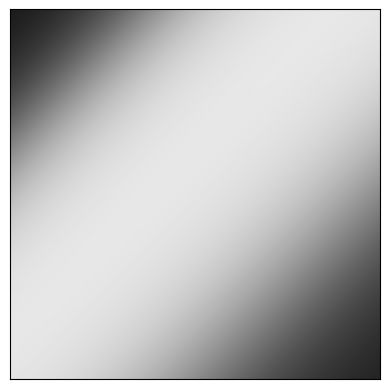

In [50]:
def grid_to_pixels() -> list[list[int]]:
    pixels = []
    for i in range(256):
        row = []
        for j in range(256):
            x = np.array([j / 256, i / 256])
            y_pred = call(model, x)[-1]

            pixel_ji = int(y_pred.flatten()[0] * 255)
            row.append(pixel_ji)
        pixels.append(row)
    return pixels


fig, ax = plt.subplots()
ax.imshow(grid_to_pixels(), cmap="gray", vmin=0, vmax=255)
ax.set_xticks([])
ax.set_yticks([])
plt.show()